## CNN Sentiment Classifier

In [1]:
import pandas as pd
import numpy as np
import torch
import torchtext
import torchdata
import portalocker
from wordsegment import load, segment
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
from itertools import combinations
from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
SEED = 313

In [3]:
MAX_LENGTH = 40

# CNN Model

This code is mainly from this source, with minor adaptations: https://colab.research.google.com/drive/1b7aZamr065WPuLpq9C4RU6irB59gbX_K#scrollTo=nU-FMtOYMx3F

This CNN is based on the methodology from the paper: Convolutional Neural Networks for Sentence Classification (Kim, 2014). 

Model Architecture: 


- input word vectors: 	fastText

- embedding size:	300

- filter sizes:	(3, 4, 5)

- num filters:	(100, 100, 100)

- activation	ReLU

- pooling:	1-max pooling

- dropout rate:	0.5


In [4]:
#from nltk.tokenize import word_tokenize
from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = tokenizer(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [5]:
tweets = pd.read_csv("tweet_eval_clean.csv")
tweets.dropna(inplace=True, subset=['text_clean'])
#tweets['word_counts'] = tweets.text_clean.str.split().map(len)
#tweets['text_clean'].replace('\d+', '', regex=True, inplace=True)
#tweets['label'] = 0
#tweets.loc[(tweets.loc[:, "sentiment"] == 'positive'), 'label'] = 2
#tweets.loc[(tweets.loc[:, "sentiment"] == 'neutral'), 'label'] = 1
MAX_LENGTH = 40

In [6]:
text_inputs = tweets["text_clean"]
text_labels = list(tweets["label"])

In [7]:
tokenized_texts, word2idx, max_len = tokenize(text_inputs)
input_ids = encode(tokenized_texts, word2idx, max_len)

In [8]:
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [141]:
embeddings = load_pretrained_vectors(word2idx, "crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...


/var/folders/8r/33488zyj26x492g8pxrnm_jh0000gn/T/ipykernel_19786/3358469232.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 37993 / 46511 pretrained vectors found.


In [18]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [19]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, text_labels, test_size=0.1, random_state=42)


In [20]:
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=3,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [22]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=3,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=3,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [23]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0
    #train_accuracies = []
    val_accuracies = []
    train_accuracies = []

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()
        loader_accuracy = []
        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)
            train_preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
            train_accuracy = (train_preds == b_labels).numpy().mean() * 100
            loader_accuracy.append(train_accuracy)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracies.append(np.mean(loader_accuracy))

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_accuracies.append(val_accuracy)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")
    
    return train_accuracies, val_accuracies

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Without Pre-Trained Embeddings

In [30]:
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train_accuracy, val_accuracy = train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.957137   |  0.885148  |   57.92   |  107.05  
   2    |   0.849622   |  0.826184  |   61.51   |   98.60  
   3    |   0.779458   |  0.800463  |   62.48   |   93.58  
   4    |   0.714897   |  0.791582  |   63.18   |   91.89  
   5    |   0.653468   |  0.794298  |   63.90   |   95.13  
   6    |   0.595115   |  0.793504  |   63.99   |   94.26  
   7    |   0.541465   |  0.818387  |   63.79   |   92.93  
   8    |   0.482607   |  0.839642  |   63.43   |   91.89  
   9    |   0.435643   |  0.865496  |   63.58   |   92.99  
  10    |   0.392825   |  0.888393  |   62.89   |   91.67  
  11    |   0.359972   |  0.930973  |   63.00   |   92.40  
  12    |   0.332196   |  0.942249  |   62.59   |   93.06  
  13    |   0.295816   |  0.997836  |   63.10   |   92.55  
  14    |   0.281298   |  1.010375  |   63.18   |   92.28  
  15    |   0.256153

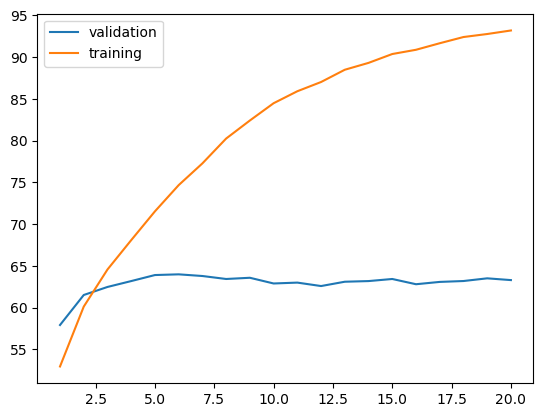

In [31]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20+1), val_accuracy, label = "validation")
plt.plot(range(1, 20+1), train_accuracy, label = "training")
plt.legend()

## Using FastText Embeddings

In [156]:
embeddings = load_pretrained_vectors(word2idx, "crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...


/var/folders/8r/33488zyj26x492g8pxrnm_jh0000gn/T/ipykernel_19786/3358469232.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 37993 / 46511 pretrained vectors found.


### Frozen FastText Embeddings

In [157]:
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.808477   |  0.720781  |   67.99   |   39.75  
   2    |   0.707843   |  0.700345  |   68.72   |   38.37  
   3    |   0.664397   |  0.691333  |   68.71   |   39.10  
   4    |   0.620587   |  0.701408  |   69.09   |   38.99  
   5    |   0.578059   |  0.711237  |   68.38   |   39.35  
   6    |   0.536285   |  0.710374  |   68.50   |   41.72  
   7    |   0.491291   |  0.743000  |   68.00   |   39.42  
   8    |   0.449757   |  0.732874  |   68.87   |   39.60  
   9    |   0.416017   |  0.753818  |   68.39   |   40.61  
  10    |   0.384611   |  0.780670  |   68.61   |   42.20  
  11    |   0.354377   |  0.823039  |   67.48   |   41.77  
  12    |   0.331851   |  0.841107  |   67.58   |   41.05  
  13    |   0.306772   |  0.851700  |   67.66   |   40.64  
  14    |   0.287259   |  0.873163  |   67.52   |   40.35  
  15    |   0.270086

([61.96495567924139,
  68.00546279117708,
  70.37940630797773,
  72.84508348794063,
  74.99793856936715,
  76.91259534116678,
  79.55555555555556,
  81.47278911564626,
  82.91104926819213,
  84.34632034632034,
  85.85992578849722,
  86.71665635951351,
  87.87095444238301,
  88.6984126984127,
  89.362296433725,
  90.19903112760257,
  90.7209853638425,
  91.09616573902288,
  91.74623788909503,
  91.91259534116678],
 [67.9859649122807,
  68.71929824561403,
  68.71403508771931,
  69.08596491228069,
  68.38070175438597,
  68.50350877192983,
  67.99736842105263,
  68.86929824561403,
  68.3859649122807,
  68.60877192982456,
  67.47543859649123,
  67.57631578947368,
  67.65877192982457,
  67.5201754385965,
  67.14736842105263,
  67.14736842105263,
  67.64824561403508,
  67.88684210526316,
  67.90350877192982,
  67.65964912280701])

In [158]:
train_accuracy, val_accuracy = ([61.96495567924139,
  68.00546279117708,
  70.37940630797773,
  72.84508348794063,
  74.99793856936715,
  76.91259534116678,
  79.55555555555556,
  81.47278911564626,
  82.91104926819213,
  84.34632034632034,
  85.85992578849722,
  86.71665635951351,
  87.87095444238301,
  88.6984126984127,
  89.362296433725,
  90.19903112760257,
  90.7209853638425,
  91.09616573902288,
  91.74623788909503,
  91.91259534116678],
 [67.9859649122807,
  68.71929824561403,
  68.71403508771931,
  69.08596491228069,
  68.38070175438597,
  68.50350877192983,
  67.99736842105263,
  68.86929824561403,
  68.3859649122807,
  68.60877192982456,
  67.47543859649123,
  67.57631578947368,
  67.65877192982457,
  67.5201754385965,
  67.14736842105263,
  67.14736842105263,
  67.64824561403508,
  67.88684210526316,
  67.90350877192982,
  67.65964912280701])

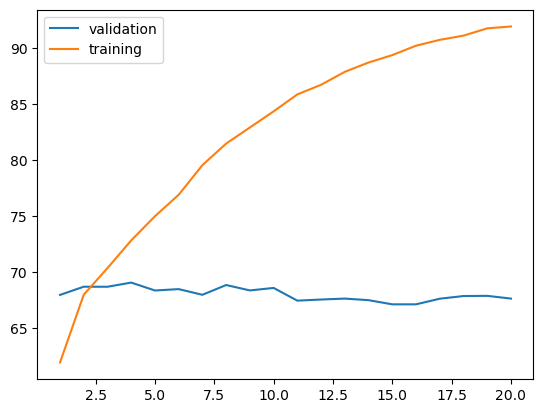

In [162]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20+1), val_accuracy, label = "validation")
plt.plot(range(1, 20+1), train_accuracy, label = "training")
plt.legend()

### Not Frozen Fast Text Embeddings

In [163]:
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train_accuracy, val_accuracy = train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.804255   |  0.715167  |   68.08   |  118.14  
   2    |   0.699162   |  0.694065  |   69.01   |  119.24  
   3    |   0.650365   |  0.684639  |   68.87   |  120.26  
   4    |   0.602937   |  0.688782  |   69.31   |  115.40  
   5    |   0.555431   |  0.704214  |   68.90   |  120.58  
   6    |   0.506643   |  0.705720  |   69.05   |  120.23  
   7    |   0.454998   |  0.730334  |   68.81   |  119.00  
   8    |   0.407145   |  0.741926  |   69.33   |  114.59  
   9    |   0.365855   |  0.774975  |   68.56   |  118.61  
  10    |   0.327325   |  0.800258  |   69.04   |  131.37  
  11    |   0.296756   |  0.858541  |   68.19   |  126.86  
  12    |   0.264201   |  0.888686  |   68.10   |  121.27  
  13    |   0.240880   |  0.902341  |   68.21   |  120.10  
  14    |   0.219569   |  0.942823  |   67.99   |  139.27  
  15    |   0.199286

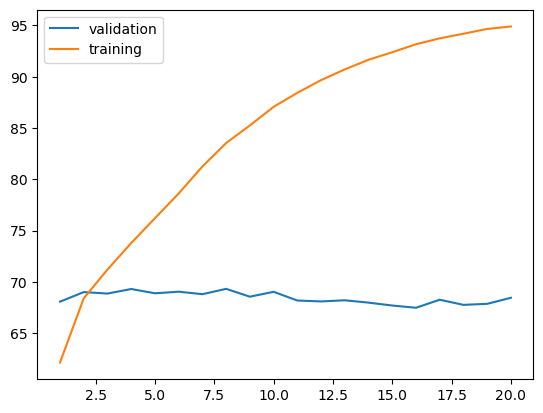

In [164]:
plt.plot(range(1, 20+1), val_accuracy, label = "validation")
plt.plot(range(1, 20+1), train_accuracy, label = "training")
plt.legend()

# Try GloVE Twitter Trained Embeddings 

In [24]:
def load_pretrained_vectors_glove(word2idx,fname):
    """Load pretrained vectors and create embedding layers for glove!
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    #print(fin)
    #n, d = map(int, fin.readline().split())
    d = 200

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings


### Create glove embeddigns

In [10]:
embeddings = load_pretrained_vectors_glove(word2idx, "glove.twitter.27B.200d.txt")
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...


/var/folders/8r/33488zyj26x492g8pxrnm_jh0000gn/T/ipykernel_1955/930119435.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin):


0it [00:00, ?it/s]

There are 38173 / 46511 pretrained vectors found.


### Frozen GloVE Embeddings

In [25]:
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=True,
                                            learning_rate=0.25,
                                            dropout=0.5)
train_accuracy, val_accuracy = train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.822428   |  0.735774  |   66.68   |   27.88  
   2    |   0.735336   |  0.717553  |   68.00   |   28.06  
   3    |   0.697261   |  0.716247  |   68.18   |   27.34  
   4    |   0.663109   |  0.707736  |   68.42   |   27.31  
   5    |   0.631666   |  0.713578  |   68.06   |   27.15  
   6    |   0.597524   |  0.732559  |   67.27   |   27.06  
   7    |   0.565773   |  0.727988  |   67.98   |   27.74  
   8    |   0.534009   |  0.750797  |   68.01   |   27.99  
   9    |   0.505251   |  0.801800  |   66.62   |   27.65  
  10    |   0.480212   |  0.774475  |   67.26   |   27.32  
  11    |   0.457106   |  0.790054  |   67.19   |   28.64  
  12    |   0.430320   |  0.793749  |   67.33   |   27.85  
  13    |   0.409262   |  0.817993  |   66.88   |   27.43  
  14    |   0.393991   |  0.832831  |   66.92   |   27.43  
  15    |   0.378630

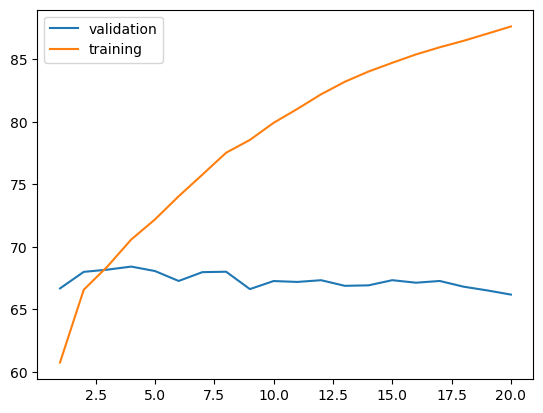

In [27]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20+1), val_accuracy, label = "validation")
plt.plot(range(1, 20+1), train_accuracy, label = "training")
plt.legend()

### Not Frozen Glove Embeddings

In [28]:
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train_accuracy, val_accuracy = train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.819547   |  0.729262  |   66.66   |   87.93  
   2    |   0.727489   |  0.711790  |   68.51   |  106.15  
   3    |   0.686116   |  0.706648  |   68.89   |   90.73  
   4    |   0.647624   |  0.703923  |   68.31   |   86.80  
   5    |   0.613121   |  0.706548  |   68.60   |  107.11  
   6    |   0.574985   |  0.734655  |   67.35   |   90.62  
   7    |   0.536102   |  0.727474  |   68.46   |  111.09  
   8    |   0.498985   |  0.751456  |   68.30   |   83.03  
   9    |   0.468029   |  0.789771  |   68.03   |   80.57  
  10    |   0.435663   |  0.797933  |   67.76   |   78.08  
  11    |   0.407134   |  0.811413  |   67.85   |   78.06  
  12    |   0.377361   |  0.837123  |   67.80   |   78.01  
  13    |   0.356965   |  0.861883  |   67.77   |   84.37  
  14    |   0.332213   |  0.880893  |   67.16   |  102.77  
  15    |   0.314632

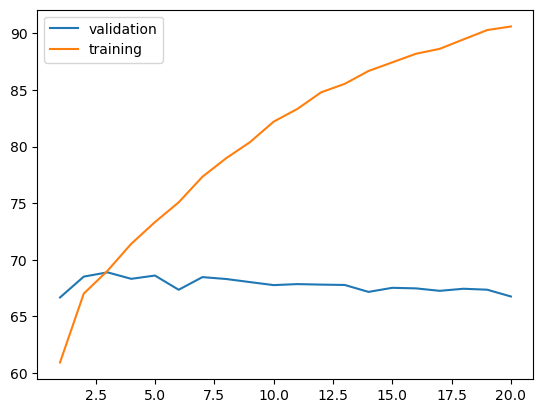

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20+1), val_accuracy, label = "validation")
plt.plot(range(1, 20+1), train_accuracy, label = "training")
plt.legend()